# Model Selection

## Packages

We begin by loading in necessary software packages, introducing options for saving the results, and software for computing PSIS LOO in Python.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import netCDF4 as nc4
import numpy as np
import pandas as pd
import logging

import pystan
import re
import time

In [2]:
# use test data (not all data is used for fitting/training)
use_testdata = False

# create plots of the data
show_data = True

# netCDF output file (set to None to not save output)
savename_output = '../results/zinser_results_full.nc'

# save the Stan output instead a few stats (only active if filename is specified above)
save_stan_output = True

save_only_converged = False

# specify the Stan variable names to save; if set to None, all variables are saved 
# (only active if save_stan_output is True)
varnames_save = None

# the number of tries to fit each Stan model to achieve an R-hat < 1.1
num_tries = 3

# the number of chains to run
num_chains = 6

# the prior_only option passed to each Stan model
prior_only = False

# Number of days of data to fit
limit_days = 2

# Whether or not data limit is inclusive (include boundary point)
inclusive = False

# Whether to append dataset to itself to create a 96-hour dataset
# This option is used for validation experiments in rolling_window.ipynb
extend = False

# Whether to append results to an existing file or overwrite
append = False

## Load, Plot Data

In [3]:
# load processed data
datafile = '../data/size_distribution/zinser_processed.nc'

dataname = 'zinser'

desc = 'Culture dataset'

# Indices of data to hold out for hold-out validation
# Uncomment desired line and set use_testdata to true
itestfile = None
# itestfile = '../data/hold_out/keep_twothirds.csv'
# itestfile = '../data/hold_out/keep_half.csv'
# itestfile = '../data/hold_out/keep_onethird.csv'

size_units = 'fg C cell$^{-1}$'


def get_data(datafile, size_units, itestfile, dataname, desc, extend=False):
    
    data_gridded = {}
    with nc4.Dataset(datafile) as nc:
        for var in nc.variables:
            data_gridded[var] = nc.variables[var][:]

    # create "counts" entry
    if 'count' in data_gridded:
        data_gridded['counts'] = (data_gridded['count'][None,:]
                                  * data_gridded['w_obs']).astype(int)
    elif 'abundance' in data_gridded:
        logging.warning('Using "abundance" data to generate count data for the model.')
        data_gridded['counts'] = (data_gridded['count'][None,:]
                                  * data_gridded['w_obs']).astype(int)
    else:
        raise RuntimeError('Cannot find a "count" or "abundance" entry in "{}".'.format(datafile))
    
    # Appends the time series to itself to create a pseudo four-day dataset
    if extend:
        data_gridded['time'] = np.concatenate((data_gridded['time'],
                                               (data_gridded['time']
                                               + data_gridded['time'][-1]
                                               + data_gridded['time'][1])[:-1]))
        
        for item in ('w_obs', 'PAR', 'abundance', 'count', 'counts'):
            if len(data_gridded[item].shape) == 2:
                data_gridded[item] = np.concatenate((data_gridded[item],
                                                     data_gridded[item][:, 1:]), axis=1)
            else:
                data_gridded[item] = np.concatenate((data_gridded[item],
                                                     data_gridded[item][1:]))

    # add description
    desc += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded)
    
    return data_gridded, desc

data_gridded, desc = get_data(datafile, size_units, itestfile, dataname, desc, extend=extend)

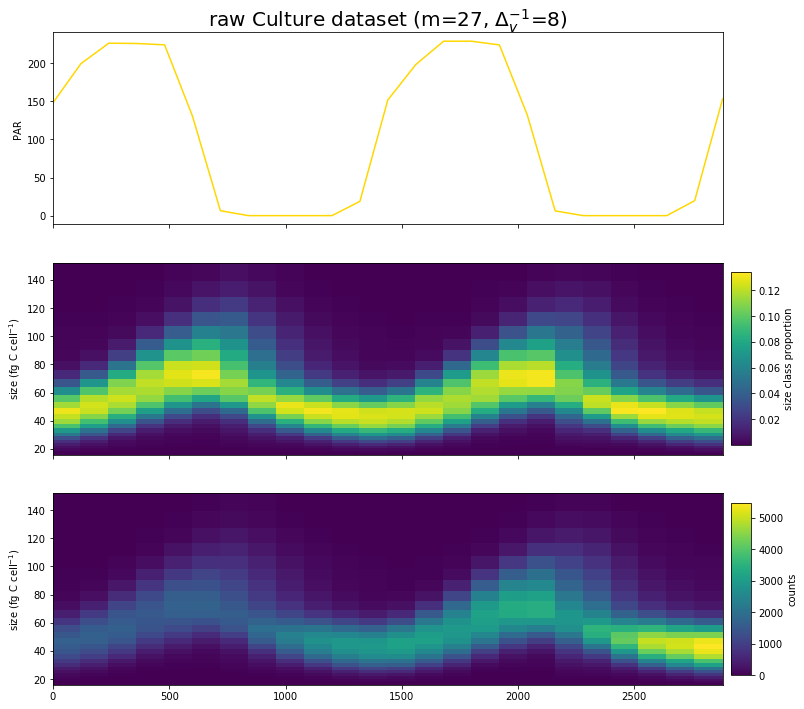

In [4]:
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5,
                            bbox_to_anchor=(0.05,0.0,1,1),
                            bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical',
                              **cbarargs)

if show_data:
    nrows = 3

    v_min = data_gridded['v_min']
    delta_v = 1.0/data_gridded['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded['m'])*delta_v) 

    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    ax.set_title('raw '+desc, size=20)
    ax.plot(data_gridded['time'], data_gridded['PAR'], color='gold')
    ax.set(ylabel='PAR')

    ax = axs[1]
    pc = ax.pcolormesh(data_gridded['time'], v, data_gridded['w_obs'],
                       shading='auto')
    ax.set(ylabel='size ({})'.format(size_units))
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

    ax = axs[2]
    pc = ax.pcolormesh(data_gridded['time'], v, data_gridded['counts'],
                       shading='auto')
    ax.set(ylabel='size ({})'.format(size_units))
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
axs[-1].set_xlabel=('time (minutes)')
None

## Process and Re-plot Data

In [5]:
# prepare data for Stan model
def data_prep(data_gridded, dt=20, limit_days=2, start=0, use_testdata=False,
              itestfile=None, prior_only=False, inclusive=False):
    
    data = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[v] = data_gridded[v]

    data['obs'] = data_gridded['w_obs']
    data['t_obs'] = data_gridded['time']
    par = data_gridded['PAR']

    if limit_days > 0:
        limit_minutes = limit_days*1440

        if inclusive:
            ind_obs = (start*60 <= data['t_obs']) & (data['t_obs'] <= limit_minutes+start*60)
        else:
            ind_obs = (start*60 <= data['t_obs']) & (data['t_obs'] < limit_minutes+start*60)

        if not np.all(ind_obs):
            total = data['obs'].shape[1]
            remove = total - data['obs'][:, ind_obs].shape[1]
            print('start is set to {}, limit_days is set to {}, removing {}/{} observation times'.format(start,
                                                                                                         limit_days,
                                                                                                         remove,
                                                                                                         total))

        data['t_obs'] = data['t_obs'][ind_obs]
        data['obs'] = data['obs'][:,ind_obs]

        data['nt'] = int(limit_minutes//data['dt']+1)

    data['nt_obs'] = data['t_obs'].size

    if use_testdata:
        # load cross-validation testing indices and add them to data
        data['i_test'] = np.loadtxt(itestfile).astype(int)
        # remove last index, so that dimensions agree
        data['i_test'] = data['i_test'][:-1]
    else:
        # set all indices to zero
        data['i_test'] = np.zeros(data['nt_obs'], dtype=int)

    # switch on or off data fitting
    data['prior_only'] = int(prior_only)

    # add light data
    t = np.arange(data['nt'])*data['dt'] + start*60
    data['E'] = np.interp(t, xp=data_gridded['time'][ind_obs], fp=par[ind_obs])

    # real count data
    data['obs_count'] = data_gridded['counts'][:, ind_obs]
    
    data['start'] = start

    # consistency check
    if len(data['i_test']) != data['nt_obs']:
        raise ValueError('Invalid number of testing indices (expected {}, got {}).'.format(data['nt_obs'],
                                                                                       len(data['i_test'])))
    return data


data = data_prep(data_gridded, dt=20, limit_days=limit_days, start=0,
                 use_testdata=use_testdata, itestfile=itestfile,
                 prior_only=prior_only, inclusive=False)

start is set to 0, limit_days is set to 2, removing 1/25 observation times


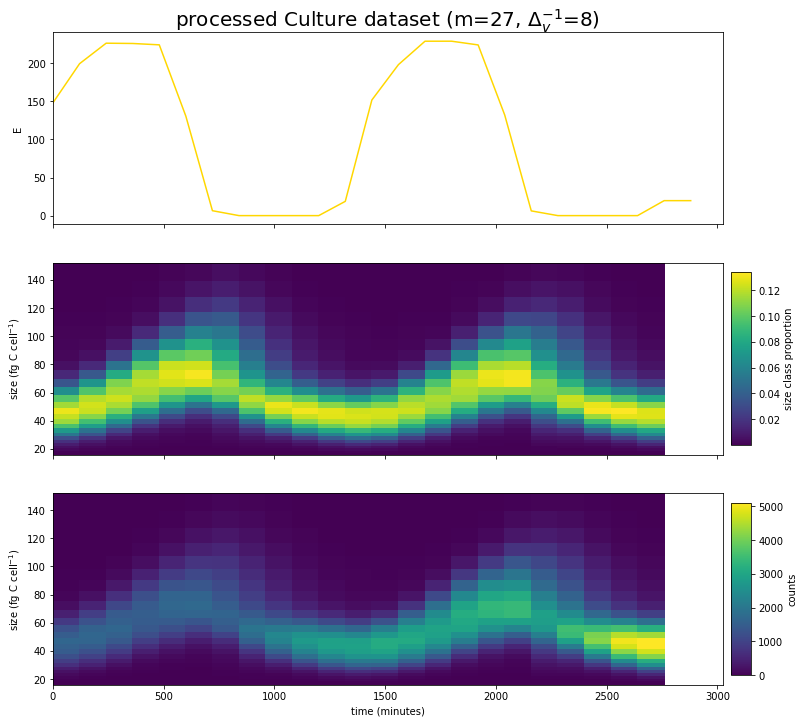

In [6]:
if show_data:
    nrows = 3

    v_min = data['v_min']
    delta_v = 1.0/data['delta_v_inv']
    v = v_min * 2**(np.arange(data['m'])*delta_v) 
    t = np.arange(data['nt'])*data['dt']


    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    ax.set_title('processed '+desc, size=20)
    ax.plot(t, data['E'], color='gold')
    ax.set(ylabel='E')

    ax = axs[1]
    pc = ax.pcolormesh(data['t_obs'], v, data['obs'], shading='auto')
    ax.set(ylabel='size ({})'.format(size_units))
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap,
                 label='size class proportion')
    ax.set_xlim(left=0.0)

    ax = axs[2]
    pc = ax.pcolormesh(data['t_obs'], v, data['obs_count'], shading='auto')
    ax.set(ylabel='size ({})'.format(size_units))
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')
None

## Choose models to fit

In [7]:
# Code files
stan_files = {
    'm_bmx': '../stan_code/m_bmx.stan',
    'm_bmb': '../stan_code/m_bmb.stan',
    'm_pmb': '../stan_code/m_pmb.stan',
    'm_fmb': '../stan_code/m_fmb.stan',
    'm_fmf': '../stan_code/m_fmf.stan',
    'm_btb': '../stan_code/m_btb.stan',
    'm_ptb': '../stan_code/m_ptb.stan',
    'm_ftb': '../stan_code/m_ftb.stan',
    'm_ftf': '../stan_code/m_ftf.stan',
}

## Fit Models and Save Results

In [8]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'models' not in globals():
    models = {}
if 'num_tries' not in globals():
    num_tries = 3
    
try_again = True
refit_all = False

refit_required = {}
stan_base_code = {}
for key, stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for model in stan_files.keys():
    code_split = stan_base_code[model].split('\n')
    stan_code[model] = '\n'.join(code_split)

In [9]:
for model in stan_files.keys():
    refit_required[model] = True
    if model in models and models[model].model_code == stan_code[model]:
        print('{}: unchanged code, not recompiling'.format(model))
        refit_required[model] = False
    else:
        if model in models:
            print('{}: code change detected, recompiling'.format(model))
        else:
            print('{}: compiling'.format(model))
        models[model] = pystan.StanModel(model_code=stan_code[model],
                                         model_name=model,
                                         obfuscate_model_name=False)


# run a bunch of experiments -- this may take a while
for model in models:
    for itry in range(num_tries):
        t0 = time.time()
        mcmcs = models[model].sampling(data=data, iter=2000, chains=num_chains)
        sampling_time = time.time() - t0  # in seconds
        print('Model {} for {}-hour window starting at {} hours fit in {} minutes.'.format(model,
                                                                                           limit_days*24+2*int(inclusive),
                                                                                           data['start'],
                                                                                           np.round(sampling_time/60, 2)))
        # get max Rhat
        rhat_max = get_max_rhat(mcmcs)
        print('{}: in try {}/{} found Rhat={:.3f}'.format(model, itry+1, num_tries, rhat_max), end='')
        if rhat_max < 1.1 or itry == num_tries - 1:
            print()
            break
        print(', trying again')

    print('{}'.format(model)) 
    print('\n'.join(x for x in mcmcs.__str__().split('\n') if '[' not in x))
    print()
    
    
    
    if 'varnames_save' not in globals():
        varnames_save = None

    if savename_output is not None:
        if model == tuple(models.keys())[0] and append == False:
            mode = 'w'
        else:
            mode = 'a'
        with nc4.Dataset(savename_output, mode) as nc:
            ncm = nc.createGroup(model)

            # write model description
            ncm.setncattr('code', stan_files[model])

            if save_stan_output:
                if save_only_converged and get_max_rhat(mcmcs) > 1.1:
                    logging.warning('Model "{}" did not converge -- skipping.'.format(model))
                    continue
                dimensions = {
                    'obstime':int(data['nt_obs']),
                    'time':int(data['nt']),
                    'sizeclass':int(data['m']),
                    'm_minus_j_plus_1':int(data['m']-data['delta_v_inv']),
                    'm_minus_1':int(data['m']-1),
                    'knots_minus_1':int(6-1),  # hardcoded, adjust for varying nknots
                    'sample': mcmcs['mod_obspos'].shape[0],
                }
                dimensions_inv = {v:k for k,v in dimensions.items()}

                for d in dimensions:
                    if d not in ncm.dimensions:
                        ncm.createDimension(d, dimensions[d])

                if 'tau[1]' in mcmcs.flatnames:
                    dimensions['tau'] = mcmcs['tau'].shape[1]
                    dimensions_inv[dimensions['tau']] = 'tau'
                    if 'tau' not in ncm.dimensions:
                        ncm.createDimension('tau', dimensions['tau'])

                if 'time' not in ncm.variables:
                    ncm.createVariable('time', int, ('time',))
                ncm.variables['time'][:] = int(data['dt']) * np.arange(data['nt'])
                ncm.variables['time'].units = 'minutes since start of experiment'

                if 'obstime' not in ncm.variables:
                    ncm.createVariable('obstime', int, ('obstime',))
                ncm.variables['obstime'][:] = data['t_obs'].astype(int)
                ncm.variables['obstime'].units = 'minutes since start of experiment'
                ncm.variables['obstime'].long_name = 'time of observations'

                for v in ('dt', 'm', 'v_min', 'delta_v_inv', 'obs', 'i_test',
                          'E', 'obs_count'):
                    if isinstance(data[v], int):
                        if v not in ncm.variables:
                            ncm.createVariable(v, int, zlib=True)
                        ncm.variables[v][:] = data[v]
                    elif isinstance(data[v], float):
                        if v not in ncm.variables:
                            ncm.createVariable(v, float, zlib=True)
                        ncm.variables[v][:] = data[v]
                    else:
                        dims = tuple(dimensions_inv[d] for d in data[v].shape)
                        if v not in ncm.variables:
                            ncm.createVariable(v, data[v].dtype, dims, zlib=True)
                        ncm.variables[v][:] = data[v]


                varnames = set(v.split('[')[0] for v in mcmcs.flatnames)
                if varnames_save is None:
                    varnames_curr = varnames
                else:
                    varnames_curr = varnames_save

                for v in varnames_curr:
                    if v in varnames:
                        dims = tuple(dimensions_inv[d]
                                     for d in mcmcs[v].shape)
                        if v not in ncm.variables:
                            ncm.createVariable(v, float, dims, zlib=True)
                        ncm.variables[v][:] = mcmcs[v]
                    else:
                        logging.warning('Cannot find variable "{}" for model "{}".'.format(v,
                                                                                           model))
            else:
                if 'sample' not in ncm.dimensions:
                    ncm.createDimension('sample',
                                        mcmcs['divrate'].shape[0])

                if 'divrate' not in ncm.variables:
                    ncm.createVariable('divrate', float, ('sample'))

                if 'sumsqdiff' not in ncm.variables:
                    ncm.createVariable('sumsqdiff', float, ('sample'))

                ncm.variables['sumsqdiff'].setncattr('long_name',
                                                     'sum of squared column differences')

                ncm.variables['divrate'][:] = mcmcs['divrate']

                obs = data['obs']

                tmp = mcmcs['mod_obspos']
                tmp /= np.sum(tmp, axis=1)[:, None, :]
                tmp -= obs[None, :, :]
                tmp **= 2

                if np.all(data['i_test'] == 0):
                    ncm.variables['sumsqdiff'][:] = np.mean(np.sum(tmp, axis=1),
                                                              axis=1)
                    ncm.variables['sumsqdiff'].setncattr('data_used',
                                                         'all data')
                else:
                    ncm.variables['sumsqdiff'][:] = np.mean(np.sum(tmp[:, :, data['i_test'] == 1],
                                                                    axis=1), axis=1)
                    ncm.variables['sumsqdiff'].setncattr('data_used', 'testing data')

                for iv,v in enumerate(('gamma_max', 'rho_max', 'xi',
                                       'xir', 'E_star')):
                    if v not in ncm.variables:
                        ncm.createVariable(v, float, ('model','sample'))
                    if v in mcmcs.flatnames:
                        ncm.variables[v][:] = mcmcs[v]

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_bmx NOW.


m_bmx: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_bmb NOW.


m_bmb: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_pmb NOW.


m_pmb: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_fmb NOW.


m_fmb: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_fmf NOW.


m_fmf: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_btb NOW.


m_btb: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_ptb NOW.


m_ptb: compiling
m_ftb: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_ftb NOW.


m_ftf: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_ftf NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_bmx for 48-hour window starting at 0 hours fit in 14.9 minutes.
m_bmx: in try 1/3 found Rhat=1.002
m_bmx
Inference for Stan model: m_bmx.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max               32.0    0.11   7.01   21.1  26.98  30.97   36.0  48.45   3837    1.0
gamma_max               6.07  5.4e-3   0.38   5.12   5.88   6.17   6.37    6.5   4933    1.0
rho_max                 3.25    0.02   1.87   0.16   1.67   3.25   4.88   6.38  12397    1.0
E_star                418.77    0.55  41.26  327.7 394.43 422.62 446.71 490.83   5638    1.0
sigma                 173.45    0.09  10.04 154.54  166.5 173.24 180.37 193.41  13733    1.0
divrate                 1.05  5.6e-4   0.05   0.96   1.02   1.05   1.08   1.14   7150    1.0
lp__                  -1.4e6    0.41  18.63 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2095

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_bmb for 48-hour window starting at 0 hours fit in 23.59 minutes.
m_bmb: in try 1/3 found Rhat=1.001
m_bmb
Inference for Stan model: m_bmb.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              49.55    0.17   9.56  32.24  42.69  48.95  56.43   69.0   3296    1.0
gamma_max               6.17  5.9e-3    0.3    5.4   6.01   6.25    6.4   6.51   2588    1.0
rho_max                 0.84  4.3e-4   0.03   0.79   0.82   0.84   0.86    0.9   4190    1.0
E_star                 263.8    0.46  22.32 211.51 251.37 267.32  279.4 299.26   2403    1.0
sigma                 348.61    0.25  19.32 311.56 335.35 348.23 361.46 387.88   5925    1.0
divrate                 0.62  2.8e-4   0.02   0.58   0.61   0.62   0.64   0.67   6853    1.0
lp__                  -1.4e6    0.38   18.8 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   244

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_pmb for 48-hour window starting at 0 hours fit in 23.16 minutes.
m_pmb: in try 1/3 found Rhat=1.002
m_pmb
Inference for Stan model: m_pmb.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max               7.92    0.02   1.53   5.68   6.84   7.69   8.72   11.6   4722    1.0
gamma_max               6.49  3.1e-4   0.03   6.41   6.47    6.5   6.51   6.52   9608    1.0
rho_max                 1.07  3.1e-4   0.03   1.02   1.05   1.07   1.09   1.12   7078    1.0
E_star                 83.75    0.08   6.57  71.37  79.23  83.43   87.9  97.49   6436    1.0
sigma                 519.43    0.28   29.0 463.66 499.71 518.96 539.27  578.2  10507    1.0
exponent_gamma         -0.55  2.1e-4   0.02  -0.58  -0.56  -0.55  -0.53  -0.51   7212    1.0
divrate                 0.33  2.1e-4   0.02    0.3   0.32   0.33   0.34   0.37   650

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_fmb for 48-hour window starting at 0 hours fit in 36.57 minutes.
m_fmb: in try 1/3 found Rhat=1.002
m_fmb
Inference for Stan model: m_fmb.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max               4.55  8.3e-3   0.63   3.59    4.1   4.46   4.88   6.06   5882    1.0
gamma_mu                4.21  3.8e-3   0.37   3.47   3.97   4.21   4.46   4.95   9562    1.0
gamma_sigma              1.8  2.6e-3   0.27   1.37   1.61   1.77   1.96   2.43  10752    1.0
rho_max                 1.09  3.1e-4   0.03   1.03   1.07   1.09    1.1   1.14   7834    1.0
E_star                121.96    0.18   10.0 102.57  115.2 121.86 128.64 142.27   3038    1.0
sigma                 647.83    0.36  36.92 577.22 622.37 647.12 672.57 722.64  10566    1.0
divrate                 0.29  2.0e-4   0.02   0.26   0.28   0.29    0.3   0.32   720

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_fmf for 48-hour window starting at 0 hours fit in 46.51 minutes.
m_fmf: in try 1/3 found Rhat=24.824, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_fmf for 48-hour window starting at 0 hours fit in 83.23 minutes.
m_fmf: in try 2/3 found Rhat=1.002
m_fmf
Inference for Stan model: m_fmf.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max               0.99  5.3e-3   0.24    0.6   0.83   0.97   1.13   1.54   2087    1.0
gamma_mu                4.99  5.5e-3   0.33   4.33   4.77   4.99   5.21   5.63   3500    1.0
gamma_sigma             1.52  3.9e-3   0.25   1.11   1.35    1.5   1.67   2.09   4039    1.0
rho_mu                  1.13  1.6e-3   0.11   0.91   1.05   1.13    1.2   1.36   4859    1.0
rho_sigma               0.54  1.6e-3   0.09   0.38   0.47   0.53   0.59   0.75   3590    1.0
E_star                 209.5     0.3   9.49 189.11 203.64 210.14 216.07 226.49   1019    1.0
sigma                 1485.7    1.31  90.57 1316.6 1423.3 1483.8 1545.3 1670.7   480

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_btb for 48-hour window starting at 0 hours fit in 18.71 minutes.
m_btb: in try 1/3 found Rhat=1.002
m_btb
Inference for Stan model: m_btb.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              70.92    0.01   1.06  68.08  70.49  71.25  71.69  71.97   9189    1.0
gamma_max               6.28  3.1e-3   0.22   5.71   6.18   6.34   6.44   6.51   4826    1.0
rho_max                 0.69  1.1e-3   0.06   0.57   0.65   0.69   0.73   0.79   2847    1.0
E_star                261.89    0.37  20.52 219.51 248.79 262.28 275.17 301.58   3141    1.0
sigma                 522.58    0.31  29.64 466.38 501.91 521.73  542.1 581.64   8869    1.0
divrate                 0.84  4.9e-4   0.04   0.77   0.81   0.84   0.87   0.92   6635    1.0
lp__                  -1.4e6    0.43  18.99 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   195

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_ptb for 48-hour window starting at 0 hours fit in 28.59 minutes.
m_ptb: in try 1/3 found Rhat=1.004
m_ptb
Inference for Stan model: m_ptb.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              48.34     0.2   6.96  37.14  43.36  47.35  52.34  64.84   1247    1.0
gamma_max               6.39  1.3e-3   0.11   6.09   6.34   6.42   6.48   6.51   7681    1.0
rho_max               5.6e-3  6.3e-5 5.4e-3 1.4e-4 1.7e-3 4.0e-3 7.9e-3   0.02   7181    1.0
E_star                164.14    0.18  12.39 140.42 155.82 163.63  172.0 189.64   4520    1.0
sigma                 1472.9    1.08  83.94 1314.5 1415.7 1470.7 1528.7 1642.9   6084    1.0
exponent_gamma         -0.71  3.2e-4   0.02  -0.75  -0.72  -0.71   -0.7  -0.67   4523    1.0
divrate                 0.94  2.4e-4   0.02   0.91   0.93   0.94   0.95   0.97   448

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_ftb for 48-hour window starting at 0 hours fit in 27.86 minutes.
m_ftb: in try 1/3 found Rhat=17.589, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_ftb for 48-hour window starting at 0 hours fit in 31.49 minutes.
m_ftb: in try 2/3 found Rhat=1.008
m_ftb
Inference for Stan model: m_ftb.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max               34.7    0.09   4.37  27.89  31.69  34.12   37.1   45.1   2444    1.0
gamma_mu                3.96  8.8e-3    0.4   3.16    3.7   3.96   4.22   4.77   2058    1.0
gamma_sigma             1.63  4.0e-3   0.26    1.2   1.44    1.6   1.78   2.23   4292    1.0
rho_max                 0.05  4.2e-4   0.03 3.9e-3   0.03   0.05   0.07   0.12   5573    1.0
E_star                286.78    0.92  26.12 230.76 270.24 288.35 305.12 334.22    814   1.01
sigma                 1765.7    1.17 105.36 1566.1 1692.1 1764.2 1837.1 1978.6   8095    1.0
divrate                  0.9  3.0e-4   0.02   0.85   0.88    0.9   0.91   0.94   642

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_ftf for 48-hour window starting at 0 hours fit in 56.82 minutes.
m_ftf: in try 1/3 found Rhat=1.007
m_ftf
Inference for Stan model: m_ftf.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              14.94    0.03   1.59   12.3  13.83  14.77  15.84  18.62   2548    1.0
gamma_mu                4.51  6.8e-3   0.37   3.77   4.27   4.51   4.75   5.23   2928    1.0
gamma_sigma             1.76  3.7e-3   0.28   1.32   1.57   1.73   1.93   2.39   5668    1.0
rho_mu                  0.45  1.3e-3   0.07   0.32   0.41   0.45   0.49   0.58   2634    1.0
rho_sigma                0.3  7.8e-4   0.05   0.22   0.27   0.29   0.33   0.42   4128    1.0
E_star                294.15    0.49  13.39 265.72  285.8 294.97 303.67 317.93    757   1.01
sigma                 3915.8    4.27 270.79 3404.0 3729.8 3905.9 4092.5 4475.2   401